In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [16]:
# -------------------------------
# Load and preprocess data
# -------------------------------
df = pd.read_csv("driver_behavior_dataset.csv")

# Encode labels
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

# Split features and labels
X = df.drop("label", axis=1)
y = df["label"]

# One-hot encode labels for categorical crossentropy
y_cat = to_categorical(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [17]:
# -------------------------------
# Build the model
# -------------------------------
def build_model(input_shape, num_classes=3):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [18]:
# -------------------------------
# Initialize Stratified K-Fold
# -------------------------------
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
acc_scores = []

for train_idx, val_idx in skf.split(X_scaled, y):
    print(f"\n--- Fold {fold} ---")

    # Split data
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y_cat[train_idx], y_cat[val_idx]

    # Build model
    model = build_model(X_train.shape[1])

    # Early stopping
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train model
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=100,
                        batch_size=16,
                        callbacks=[early_stop],
                        verbose=0)

    # Evaluate
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation Accuracy: {val_acc:.4f}")

    acc_scores.append(val_acc)

    fold += 1

# Print results
print("\n=== Final Cross-Validation Results ===")
print("Accuracy per fold:", [f"{acc:.4f}" for acc in acc_scores])
print(f"Mean Accuracy: {np.mean(acc_scores):.4f}")
print(f"Std Dev Accuracy: {np.std(acc_scores):.4f}")


--- Fold 1 ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation Accuracy: 0.9821

--- Fold 2 ---
Validation Accuracy: 0.9911

--- Fold 3 ---
Validation Accuracy: 0.9911

--- Fold 4 ---
Validation Accuracy: 0.9946

--- Fold 5 ---
Validation Accuracy: 0.9875

=== Final Cross-Validation Results ===
Accuracy per fold: ['0.9821', '0.9911', '0.9911', '0.9946', '0.9875']
Mean Accuracy: 0.9893
Std Dev Accuracy: 0.0042


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Classification Report:
              precision    recall  f1-score   support

  aggressive       1.00      1.00      1.00        60
        idle       1.00      0.75      0.86        40
      normal       0.86      1.00      0.92        60

    accuracy                           0.94       160
   macro avg       0.95      0.92      0.93       160
weighted avg       0.95      0.94      0.94       160



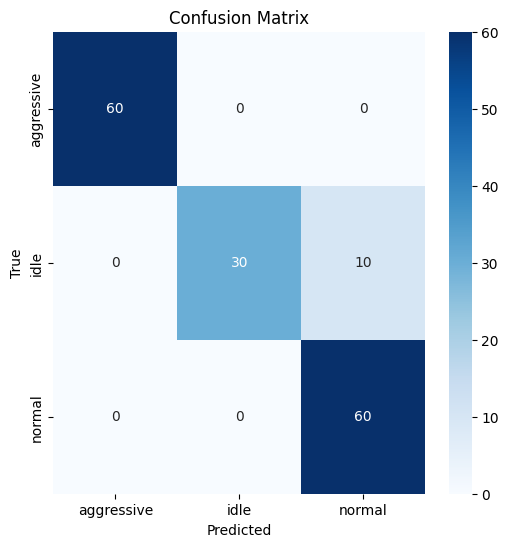

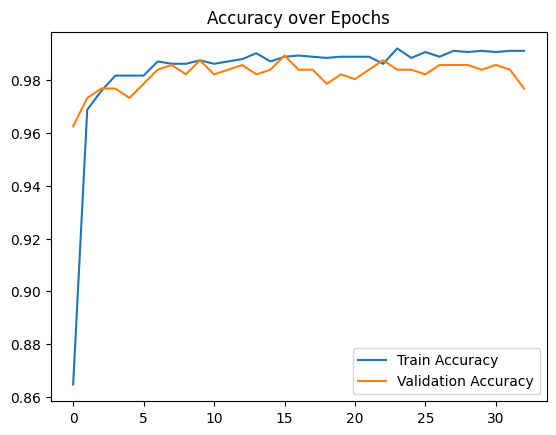

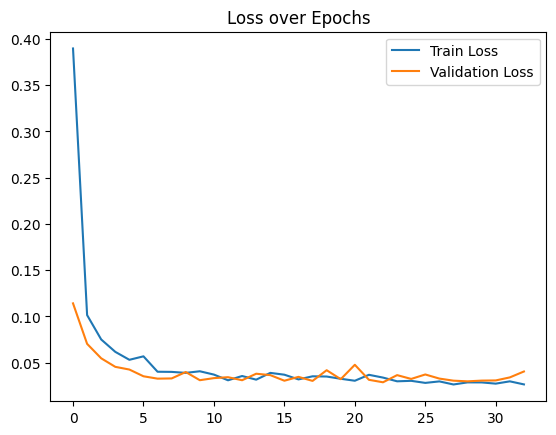

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9444 - loss: 0.2541 

Test Loss: 0.3312, Test Accuracy: 0.9375


In [19]:
# -------------------------------
# Evaluate model
# -------------------------------
# Predict probabilities and convert to class labels
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

# Keras evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f'\nTest Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

In [20]:
# -------------------------------
# Convert to TensorFlow Lite
# -------------------------------
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save TFLite model
with open('driver_behavior_model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model saved as 'driver_behavior_model.tflite'")

Saved artifact at '/tmp/tmp6ly9l0d5'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 4), dtype=tf.float32, name='keras_tensor_77')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  135863461026832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135863319039056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135863319038096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135863319048272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135863319035984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135863319049232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135863319037520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135863319038480: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model saved as 'driver_behavior_model.tflite'
